Working:
1. Spectroscopy.
    - Plotting data and names of all elements needs to be tweeked for clarity/think about best implementation
    - SPECTROSCOPY_IQ vs SPECTROSCOPY_PSD investigation.
2. Punchout
    - Plotting data and names of all eleents needs to be tweeked for clarity/think about best implementation
    - SPECTROSCOPY_IQ vs SPECTROSCOPY_PSD investigation.
3. Single and double flux tuning at a single frequency
    - Again needs better plotting support and infrastructure
 
Need to create:
1. Wide spectrum support

## Imports 

In [24]:
from pathlib import Path
import datetime
from datetime import date
import pandas as pd
import time
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
import sys
import logging

from qcodes.instrument_drivers.yokogawa.GS200 import GS200

from laboneq.simple import *
import laboneq.pulse_sheet_viewer.pulse_sheet_viewer as psv
from laboneq.contrib.example_helpers.plotting.plot_helpers import plot_simulation
from laboneq.contrib.example_helpers.descriptors.shfsg_shfqa_pqsc import (
    descriptor_shfsg_shfqa_pqsc,
)
from laboneq.analysis.fitting import (
    lorentzian,
    oscillatory,
    oscillatory_decay,
    exponential_decay,
)

In [26]:
#Note how currently the drive line for q0 and q1 and q2 are the same
descriptor_shfqc = """
instruments:
  SHFQC:
  - address: DEV12195
    uid: device_shfqc
    interface: 1gbe
    options: SHFQC/PLUS/QC6CH

connections:
  device_shfqc:
    - iq_signal: q0/drive_line
      ports: SGCHANNELS/0/OUTPUT

    - iq_signal: q0/measure_line
      ports: [QACHANNELS/0/OUTPUT]
    - acquire_signal: q0/acquire_line
      ports: [QACHANNELS/0/INPUT]

    - iq_signal: q1/drive_line
      ports: SGCHANNELS/1/OUTPUT

    - iq_signal: q1/measure_line
      ports: [QACHANNELS/0/OUTPUT]
    - acquire_signal: q1/acquire_line
      ports: [QACHANNELS/0/INPUT]
      
    - iq_signal: q2/drive_line
      ports: SGCHANNELS/2/OUTPUT
      
    - iq_signal: q2/measure_line
      ports: [QACHANNELS/0/OUTPUT]
    - acquire_signal: q2/acquire_line
      ports: [QACHANNELS/0/INPUT]
"""

In [27]:
# Define and Load our Device Setup
device_setup = DeviceSetup.from_descriptor(
    yaml_text=descriptor_shfqc, # the yaml gives the full description of the logical signal layout
    server_host="localhost",  # ip address of the LabOne dataserver used to communicate with the instruments
    server_port="8004",  # port number of the dataserver - default is 8004
    setup_name="my_setup",  # setup name
)

# define shortcut to logical signals for convenience
lsg = {
    qubit_name: device_setup.logical_signal_groups[qubit_name].logical_signals
    for qubit_name in device_setup.logical_signal_groups.keys()
}

## Connect to Auxillary Instruments

In [28]:
try:
    dc = GS200('yoko_right', address = 'TCPIP0::192.168.4.157::inst0::INSTR')
except Exception as e:
    print(e)

try:
    coil= GS200('yoko_left', address = 'TCPIP0::192.168.4.208::inst0::INSTR')
except Exception as e:
    print(e)

Connected to: YOKOGAWA GS210 (serial:91S621541, firmware:2.02) in 0.02s
'Another instrument has the name: yoko_right'
Connected to: YOKOGAWA GS210 (serial:91PC11413, firmware:2.02) in 0.02s
'Another instrument has the name: yoko_left'


In [ ]:
# dc.BNC_out.set('ready') # this sets a low signal signaure right after the move has been completed
# dc.BNC_out.get()
dc.ramp_current(0e-3, 1e-6,0.02)
dc.output('off')
dc.source_mode('CURR')
dc.ramp_current(0e-3, 1e-6,0.02)
dc.output('on')
dc.current_range(0.01)

# coil.BNC_out.set('ready') # this sets a low signal signature right after the move has been completed
# coil.BNC_out.get()
coil.ramp_current(0e-3, 1e-6,0.02)
coil.output('off')
coil.source_mode('CURR')
coil.ramp_current(0e-3, 1e-6,0.02)
coil.output('on')
coil.current_range(0.01)

# dc.current.get()
# coil.current.get()

In [30]:
coil.ramp_current(-122e-6, 1e-7, 0.01) #Currently the sweepspot for the F0 fluxonium

The logical signal group is what defines the set of logical parameters for measurements. This needs to get assigned to an experimental signal group in the Experiment class connecting theory with device_setup (shown later).

In [52]:
#GKP1
q0 = Transmon.from_logical_signal_group(
    uid="q0",
    lsg=device_setup.logical_signal_groups["q0"],
    parameters=TransmonParameters(
        resonance_frequency_ge=3e9,
        readout_resonator_frequency=7111210042,
        readout_lo_frequency=7.1e9,
        readout_integration_delay=95e-9,
        readout_range_out=-5,
        readout_range_in=5,
        drive_lo_frequency=3e9,
        drive_range=0,
        user_defined={
            "amplitude_pi": 1,
            "pulse_length": 50e-9,
            "readout_len": 2e-6,
            "readout_amp": 0.9,
            "reset_length": 5e-6,
        }
    )
)

#Test Transmon (T0)
q1 = Transmon.from_logical_signal_group(
    uid="q1",
    lsg=device_setup.logical_signal_groups["q1"],
    parameters=TransmonParameters(
        resonance_frequency_ge=4.919995e9,
        readout_resonator_frequency=6421000000,
        readout_lo_frequency=6.8e9,
        readout_integration_delay=90e-9,
        readout_range_out=-5,
        readout_range_in=5,
        drive_lo_frequency=4.8e9,
        drive_range=-10,
        user_defined={
            "amplitude_pi": 0.425,
            "pulse_length": 100e-9,
            "readout_len": 2e-6,
            "readout_amp": 1,
            "reset_length": 5e-6,
        }
    )
)

#Fluxionium 1
q2 = Transmon.from_logical_signal_group( 
    uid="q2",
    lsg=device_setup.logical_signal_groups["q2"],
    parameters=TransmonParameters(
        resonance_frequency_ge=2e9,
        readout_resonator_frequency=6.763e9,
        readout_lo_frequency=6.8e9,
        readout_integration_delay=93e-9,
        readout_range_out=-10,
        readout_range_in=5,
        drive_lo_frequency=2e9,
        drive_range=-10,
        user_defined={
            "amplitude_pi": 0.425,
            "pulse_length": 100e-9,
            "readout_len": 2e-6,
            "readout_amp": 1,
            "reset_length": 5e-6,
            "readout_power": -10 #max power in dBm for readout pre_punchout
        }
    )
)

In [31]:
qubit=q2 #Defines which qubit we are actually doing all the measuring of. Important.
averages=2**7
device_setup.set_calibration(qubit.calibration()) #This sets the settings defined in the qubit params
# device_setup.get_calibration() #Here for checking if all the calibration went well.

## Defining Real-Time Calls
Seems as if the QCoDes intruments cannot be pickled into the experiment when it is sent to the HFSQC. To get around this, do not pass the QCoDes object as a parameter to the call. Just have that name be in the global namespace which makes sure it is handled by the computer.

In [32]:
def change_dc_current(session, new_current, step_time):
    dc.ramp_current(new_current, 1e-6, step_time)
    # print("DC Current " + str(new_current))
dc_sweep_param = LinearSweepParameter(
    uid='DC Current', start=-600e-6, stop=600e-6, count=301)

def change_coil_current(session, new_current, step_time):
    coil.ramp_current(new_current, 1e-7, step_time)
    print("Current coil current: " + str(new_current))
coil_sweep_param = LinearSweepParameter(
    uid='Coil Current', start=-250e-6, stop=-50e-6, count=101)

def sweep_progress(session, linearsweepparameter):
    print(str(linearsweepparameter.count))

In [9]:
# ONLY KEEPING FOR SHORT SIMPLE SCANS
dc_sweep_param = LinearSweepParameter(
    uid='DC Current', start=0e-6, stop=4e-6, count=5)

coil_sweep_param = LinearSweepParameter(
    uid='Coil Current', start=-1000e-6, stop=1000e-6, count=1001)

In [ ]:
100e-6, stop=400e-6, count=81)

lsg['q0']['drive_line'].currents = coil_sweep_param

## Defining an Experiment
Here, signal mapping sets a label of how the "ExperimentSignal" maps to ("map_to") the logical signal groups of each qubit.

In [27]:
exp = Experiment(
    uid="General_Experiment",
    signals=[
        ExperimentSignal(uid="measure", map_to=lsg[qubit.uid]['measure_line']),
        ExperimentSignal(uid="acquire", map_to=lsg[qubit.uid]['acquire_line']),
        ExperimentSignal(uid="drive", map_to=lsg[qubit.uid]['drive_line'])
    ]
)

In [33]:
readout_pulse = pulse_library.gaussian_square(
    uid=f"readout_pulse_{qubit.uid}",
    length=qubit.parameters.user_defined['readout_len'],
    amplitude=qubit.parameters.user_defined['readout_amp']*0.01,
    width=qubit.parameters.user_defined['readout_len']*0.9,
    sigma=0.2,)

### Measures the resonator at a single point

In [36]:
# Is now working now that there is a kernel for the integration (in integration mode). For ease, I am having the kernel be the same as the applied drive pulse.
exp = Experiment(
    uid="Single Point Readout",
    signals=[
        ExperimentSignal(uid="measure", map_to=lsg[qubit.uid]['measure_line']),
        ExperimentSignal(uid="acquire", map_to=lsg[qubit.uid]['acquire_line']),
        ExperimentSignal(uid="drive", map_to=lsg[qubit.uid]['drive_line'])
    ]
)

with exp.acquire_loop_rt(
    uid='shots',
    count=averages,
    averaging_mode=AveragingMode.CYCLIC,
    acquisition_type=AcquisitionType.INTEGRATION,
):
    with exp.section(uid="Pulsed Single Frequency Readout"):
        exp.play(
            signal="measure",
            pulse=readout_pulse
        )
        exp.acquire( #acquire on its own seems to be able to measure things, but not as well(?)
            signal='acquire',
            handle='single_freq_data',
            length=qubit.parameters.user_defined['readout_len'],
            kernel=readout_pulse #this is important to actually integrate against so the result is non-zero
        )
    with exp.section(uid="delay_between_readout", length=qubit.parameters.user_defined['reset_length']):
        exp.reserve(signal='measure')

### 1D Flux Sweep

In [37]:
# This one is a direct copy of my working spectroscopy scan but now includes a 1D resonator sweep.
ro_frequency_sweep = LinearSweepParameter(
    uid='Readout Frequency Sweep', start=-40e6, stop=-35e6, count=101) #NOTE! This is the frequency offset from the LO
current_sweep_param = coil_sweep_param #Simply change coil_sweep_param to dc_sweep param for dc sweep.

exp = Experiment(
    uid="1D Current vs Resonator",
    signals=[
        ExperimentSignal(uid="measure", map_to=lsg[qubit.uid]['measure_line']),
        ExperimentSignal(uid="acquire", map_to=lsg[qubit.uid]['acquire_line']),
        ExperimentSignal(uid="drive", map_to=lsg[qubit.uid]['drive_line'])
    ]
)

with exp.sweep(
    uid="Yoko Sweep",
    parameter=current_sweep_param,
    execution_type=ExecutionType.NEAR_TIME,
):
    exp.call('Change Current', new_current=current_sweep_param, step_time=0.01) 
    with exp.acquire_loop_rt(
        uid='shots',
        count=averages,
        averaging_mode=AveragingMode.CYCLIC,
        acquisition_type=AcquisitionType.SPECTROSCOPY,
    ):
        with exp.sweep(
                uid='Readout Resonator Frequency Sweep',
                parameter=ro_frequency_sweep,
                reset_oscillator_phase=True
            ):
                with exp.section(uid="Pulsed Single Frequency Readout"):
                    exp.play(
                        signal="measure",
                        pulse=readout_pulse
                    )
                    exp.acquire( #acquire on its own seems to be able to measure things, but not as well(?)
                        signal='acquire',
                        handle='single_freq_data',
                        length=qubit.parameters.user_defined['readout_len'],
                    )
                with exp.section(uid="delay_between_readout", length=qubit.parameters.user_defined['reset_length']):
                    exp.reserve(signal="measure")

### 2D Flux Sweep (Inner loop is DC, Outer loop is Coil)
- Would be nice to have a faster flux sweep functionality at the end (or beginning?) of each loop

In [40]:
exp = Experiment(
    uid="2D Current Sweep",
    signals=[
        ExperimentSignal(uid="measure", map_to=lsg[qubit.uid]['measure_line']),
        ExperimentSignal(uid="acquire", map_to=lsg[qubit.uid]['acquire_line']),
        ExperimentSignal(uid="drive", map_to=lsg[qubit.uid]['drive_line'])
    ]
)

with exp.sweep(
    uid='coil sweep',
    parameter=coil_sweep_param,
    execution_type=ExecutionType.NEAR_TIME,
):
    exp.call(change_coil_current, new_current=coil_sweep_param, step_time=0.01)
    with exp.sweep(
        uid="dc sweep",
        parameter=dc_sweep_param,
        execution_type=ExecutionType.NEAR_TIME,
    ):
        exp.call(change_dc_current, new_current=dc_sweep_param, step_time=0.01) #note that "argument" session (first argument to the function) is automatically passed
        with exp.acquire_loop_rt(
            uid="shots",
            count=averages,
            acquisition_type=AcquisitionType.SPECTROSCOPY_IQ,
            averaging_mode=AveragingMode.SEQUENTIAL
        ):
            with exp.section(uid="Pulsed Single Frequency Readout"):
                exp.play(
                    signal="measure",
                    pulse=readout_pulse
                )
                exp.acquire(
                    signal='acquire',
                    handle='single_freq_data',
                    kernel=readout_pulse,
                    length=qubit.parameters.user_defined['readout_len'],
                )
            with exp.section(uid="delay_between_readout", length=qubit.parameters.user_defined['reset_length']):
                exp.reserve(signal="measure")

### Readout Resonator Trace

In [41]:
ro_frequency_sweep = LinearSweepParameter(
    uid='Readout Frequency Sweep', start=-40e6, stop=-35e6, count=401) #NOTE! This is the frequency offset from the LO. Need better integration for ease of use.

exp = Experiment(
    uid="Resonator Trace",
    signals=[
        ExperimentSignal(uid="measure", map_to=lsg[qubit.uid]['measure_line']),
        ExperimentSignal(uid="acquire", map_to=lsg[qubit.uid]['acquire_line']),
        ExperimentSignal(uid="drive", map_to=lsg[qubit.uid]['drive_line'])
    ]
)

with exp.acquire_loop_rt(
    uid='shots',
    count=averages,
    averaging_mode=AveragingMode.CYCLIC,
    acquisition_type=AcquisitionType.SPECTROSCOPY,
):
    with exp.sweep(
        uid='Readout Frequency Sweep',
        parameter=ro_frequency_sweep,
        reset_oscillator_phase=True
    ):
        with exp.section(uid="Pulsed Single Frequency Readout"):
            exp.play(
                signal="measure",
                pulse=readout_pulse
            )
            exp.acquire( #acquire on its own seems to be able to measure things, but not as well(?)
                signal='acquire',
                handle='single_freq_data',
                length=qubit.parameters.user_defined['readout_len'],
            )
        with exp.section(uid="delay_between_readout", length=qubit.parameters.user_defined['reset_length']):
            exp.reserve(signal="measure")

### Punchout
This works, but the power sweep is NEAR_TIME. Putting it in the REAL_TIME section makes the play channel seem like there are multiple envelopes for the readout pulse? Might be becasue of some timing or alignement issue... For now it seems fine given that the loop only needs to be executed a handful of times.

In [43]:
#Note this is a power sweep of the pulse amplitude, not of powers!
power_sweep = SweepParameter(
    uid='Readout Power', values=np.logspace(start=-2,stop=0,num=10,base=10))

exp = Experiment(
    uid="Punchout",
    signals=[
        ExperimentSignal(uid="measure", map_to=lsg[qubit.uid]['measure_line']),
        ExperimentSignal(uid="acquire", map_to=lsg[qubit.uid]['acquire_line']),
        ExperimentSignal(uid="drive", map_to=lsg[qubit.uid]['drive_line'])
    ]
)

with exp.sweep(
    uid='Power sweep',
    parameter=power_sweep,
):
    with exp.acquire_loop_rt(
        uid='shots',
        count=averages,
        averaging_mode=AveragingMode.SEQUENTIAL,
        acquisition_type=AcquisitionType.SPECTROSCOPY,
    ):
    
        with exp.sweep(
            uid='Readout Frequency Sweep',
            parameter=ro_frequency_sweep,
            reset_oscillator_phase=True
        ):
            with exp.section(uid="single_res_point_readout"):
                exp.play(
                    signal="measure",
                    pulse=readout_pulse,
                    amplitude=power_sweep,
                )
                exp.acquire(
                    signal='acquire',
                    handle='single_freq_data',
                    length=qubit.parameters.user_defined['readout_len'],
                )
            with exp.section(uid="delay_between_readout", length=qubit.parameters.user_defined['reset_length']):
                exp.reserve(signal="measure")

### Spectroscopy
-Unclear still how to have the LO naturally move during the sweep. Maybe build it into a function call?
-For some reason, the drive frequency sweep is upset that it is in real-time. Need to investigate further.

In [46]:
drive_freq_sweep = LinearSweepParameter(
    uid='Drive Frequency', start=-200e5, stop=200e5, count=201)

exp = Experiment(
    uid="Spectroscopy",
    signals=[
        ExperimentSignal(uid="measure", map_to=lsg[qubit.uid]['measure_line']),
        ExperimentSignal(uid="acquire", map_to=lsg[qubit.uid]['acquire_line']),
        ExperimentSignal(uid="drive", map_to=lsg[qubit.uid]['drive_line'])
    ]
)
with exp.acquire_loop_rt(
    uid='shots',
    count=averages,
    averaging_mode=AveragingMode.CYCLIC,
    acquisition_type=AcquisitionType.INTEGRATION,
):
    with exp.sweep(
        uid='Drive Frequency Sweep',
        parameter=drive_freq_sweep,
    ):
        with exp.section(uid='Play drive'):
            exp.reserve(signal='measure')
            exp.play(
                signal="drive",
                pulse=pulse_library.gaussian_square(
                uid=f"drive_pulse_{qubit.uid}",
                length=100e-9,
                width=100e-9*0.9,
                sigma=0.2,),
        )       
        with exp.section(uid="single_res_point_readout"):
            exp.play(
                signal="measure",
                pulse=readout_pulse
            )
            exp.acquire( #acquire on its own seems to be able to measure things, but not as well(?)
                signal='acquire',
                handle='single_freq_data',
                length=qubit.parameters.user_defined['readout_len'],
                kernel=readout_pulse #this is important to actually integrate against so the result is non-zero
            )
        with exp.section(uid="delay_between_readout", length=qubit.parameters.user_defined['reset_length']):
            exp.reserve(signal="measure")

## Calibration for the Experiment
- Would ideally have calibration ala the device_setup instead of through the experiment calibration
- Would also like to add a delay to the calibration of all this instead of having it be through a manual readout pulse delay
- Should have a time stamp and fractional counter each time the current updates to have a sense of progress
- Think of a way to usably implement session.abort_execution()...

### Device Calibration
This does device calibration rather than experiment specific calibration. Note, this calibration is for frequency sweeps.

In [67]:
device_calibration = Calibration()

readout_osc = Oscillator(
    "readout_osc",
    frequency=ro_frequency_sweep,
    modulation_type=ModulationType.HARDWARE)
drive_osc = Oscillator(
    "drive_osc",
    frequency=qubit.parameters.resonance_frequency_ge,
    modulation_type=ModulationType.HARDWARE)
device_calibration["measure"] = SignalCalibration(
    oscillator=readout_osc)
device_calibration["acquire"] = SignalCalibration(
    oscillator=readout_osc)
device_calibration["drive"] = SignalCalibration(
    local_oscillator=drive_osc)
device_setup.set_calibration(device_calibration)

This does device calibration rather than experiment specific calibration. Note, this calibration is for fixed frequency runs.

In [49]:
device_calibration = Calibration()

readout_osc = Oscillator(
    "readout_osc",
    frequency=qubit.parameters.readout_resonator_frequency,
    modulation_type=ModulationType.HARDWARE)
drive_osc = Oscillator(
    "drive_osc",
    frequency=qubit.parameters.resonance_frequency_ge,
    modulation_type=ModulationType.HARDWARE)
device_calibration["measure"] = SignalCalibration(
    oscillator=readout_osc)
device_calibration["acquire"] = SignalCalibration(
    oscillator=readout_osc)
device_calibration["drive"] = SignalCalibration(
    local_oscillator=drive_osc)
device_setup.set_calibration(device_calibration)

### Experimental Calibration
This is experimental calibration (in case for some reason calibration is wished to be made specific to this experiment). These settings in general will superseed the settings of the device_setup.
- Note that this is for single frequency readout at the qubit's resonator frequency 

This is for drive frequency sweeps

In [47]:
exp_calibration = Calibration()
readout_osc = Oscillator(
    "readout_osc",
    frequency=qubit.parameters.readout_resonator_frequency,
    modulation_type=ModulationType.HARDWARE)
drive_osc = Oscillator(
    "drive_osc",
    frequency=drive_freq_sweep,
    modulation_type=ModulationType.HARDWARE)
exp_calibration["measure"] = SignalCalibration(
    oscillator=readout_osc,)
exp_calibration["acquire"] = SignalCalibration(
    oscillator=readout_osc)
exp_calibration["drive"] = SignalCalibration(
    local_oscillator=drive_osc)
exp.set_calibration(exp_calibration)
# session.experiment_calibration

- Use this calibration for frequency sweeps of readout line

In [33]:
exp_calibration = Calibration()
readout_osc = Oscillator(
    "readout_osc",
    frequency=ro_frequency_sweep,
    modulation_type=ModulationType.HARDWARE)
drive_osc = Oscillator(
    "drive_osc",
    frequency=qubit.parameters.resonance_frequency_ge,
    modulation_type=ModulationType.HARDWARE)
exp_calibration["measure"] = SignalCalibration(
    oscillator=readout_osc,)
exp_calibration["acquire"] = SignalCalibration(
    oscillator=readout_osc)
exp_calibration["drive"] = SignalCalibration(
    local_oscillator=drive_osc)
exp.set_calibration(exp_calibration)
# session.experiment_calibration

## Compile Session
Do final checks before running the job.

In [51]:
session = Session(
    device_setup=device_setup,
    log_level = logging.WARNING,
    experiment=exp)
session.connect(use_async_api=True);
session.register_neartime_callback(change_dc_current, 'change_current')
session.register_neartime_callback(change_coil_current, 'change_current')
compiled_session = session.compile(exp);
psv.interactive_psv(compiled_session, max_events_to_publish=10000, )

LabOneQException: Parameter Drive Frequency can't be swept in real-time, it is bound to a value that can only be set in near-time

## Run session
- Think about how to implement session.queue() since this could allow the device to always be measuring something

In [14]:
results = session.run()
my_results = session.get_results() #a deep copy of session.results
my_acquired_results = my_results.acquired_results['single_freq_data'] #extracts data from the exp.acquire method with the same key name

LabOneQException: No experiment available to run.

## Plot and Analyze Data

In [71]:
my_results.acquired_results

{'single_freq_data': AcquiredResult(data=(0.000557322917284974-0.0009778748897522511j), axis_name=[], axis=[], last_nt_step=[], handle='single_freq_data')}

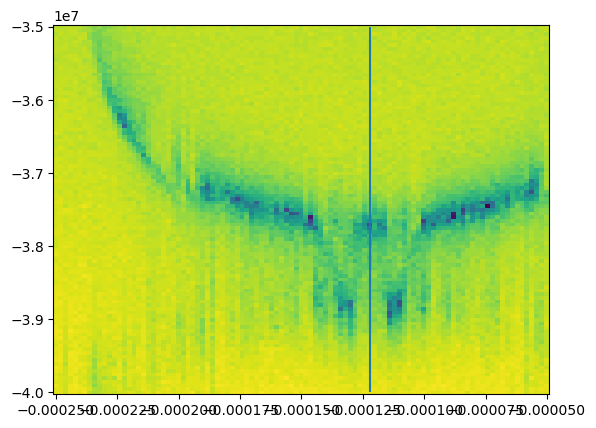

In [26]:
#plotting resonator over flux
plt.pcolor(my_acquired_results.axis[0],
           my_acquired_results.axis[1], 
           np.log(np.abs(my_acquired_results.data).T),
           shading='nearest')
plt.vlines(x=-122e-6, ymin=-4e7, ymax=-3.5e7)

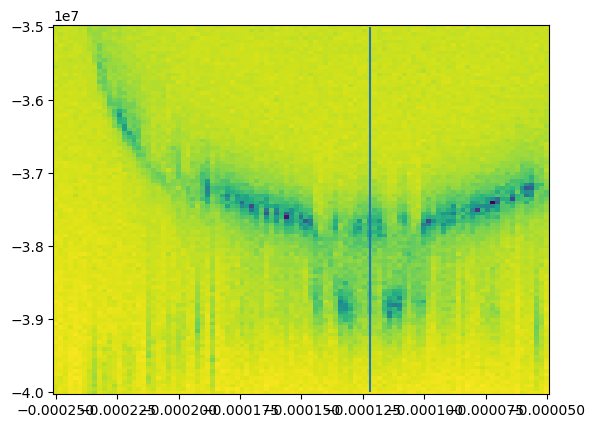

In [22]:
#plotting resonator over flux
plt.pcolor(my_acquired_results.axis[0],
           my_acquired_results.axis[1], 
           np.log(np.abs(my_acquired_results.data).T),
           shading='nearest')
plt.vlines(x=-122e-6, ymin=-4e7, ymax=-3.5e7)

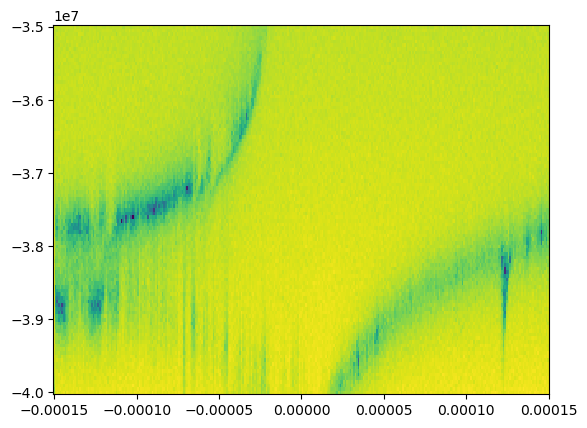

In [12]:
#plotting resonator over flux
plt.pcolor(my_acquired_results.axis[0],
           my_acquired_results.axis[1], 
           np.log(np.abs(my_acquired_results.data).T),
           shading='nearest')

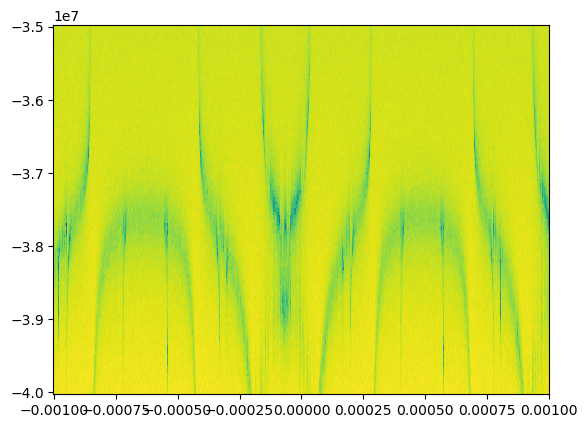

In [105]:
#plotting resonator over flux
plt.pcolor(my_acquired_results.axis[0],
           my_acquired_results.axis[1], 
           np.log(np.abs(my_acquired_results.data).T),
           shading='nearest')

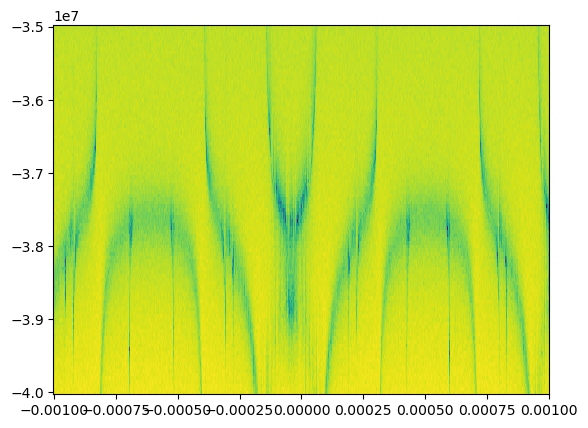

In [103]:
#plotting resonator over flux
plt.pcolor(my_acquired_results.axis[0],
           my_acquired_results.axis[1], 
           np.log(np.abs(my_acquired_results.data).T),
           shading='nearest')

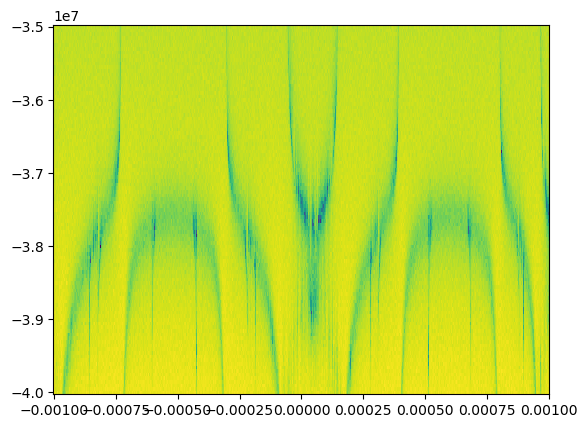

In [89]:
#plotting resonator over flux
plt.pcolor(my_acquired_results.axis[0],
           my_acquired_results.axis[1], 
           np.log(np.abs(my_acquired_results.data).T),
           shading='nearest')

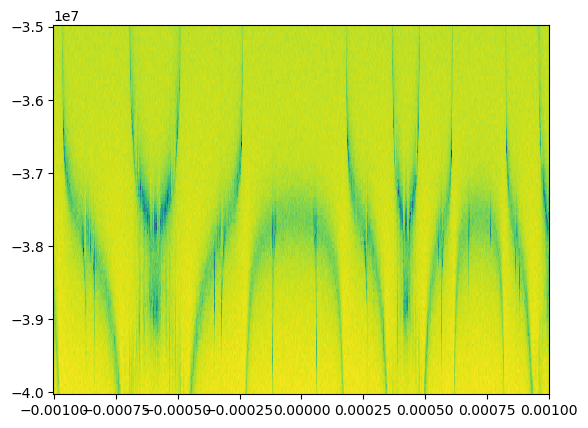

In [77]:
#plotting resonator over flux
plt.pcolor(my_acquired_results.axis[0],
           my_acquired_results.axis[1], 
           np.log(np.abs(my_acquired_results.data).T),
           shading='nearest')

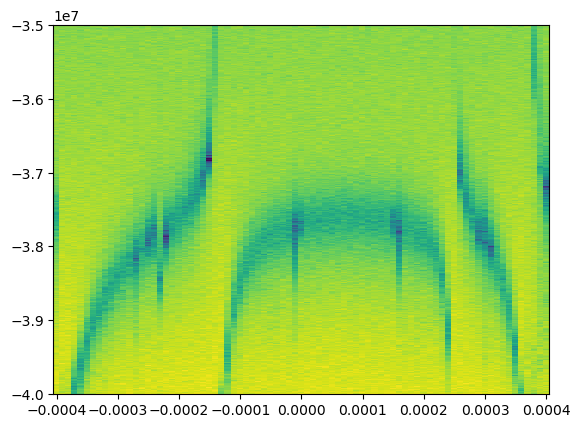

In [71]:
#plotting resonator over flux
plt.pcolor(my_acquired_results.axis[0],
           my_acquired_results.axis[1], 
           np.log(np.abs(my_acquired_results.data).T),
           shading='nearest')

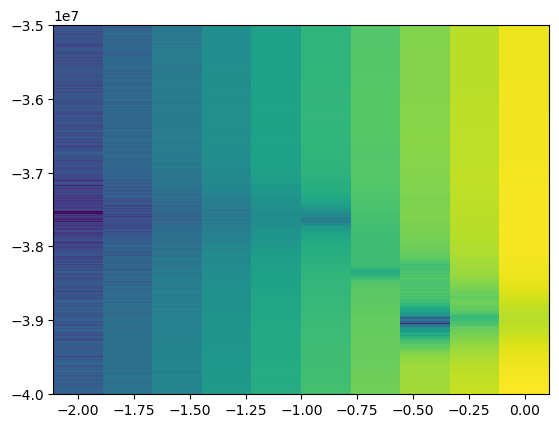

In [101]:
# For plotting punchout
plt.pcolor(np.log10(my_acquired_results.axis[0]),
           my_acquired_results.axis[1], 
           np.log(np.abs(my_acquired_results.data).T),
           shading='nearest')

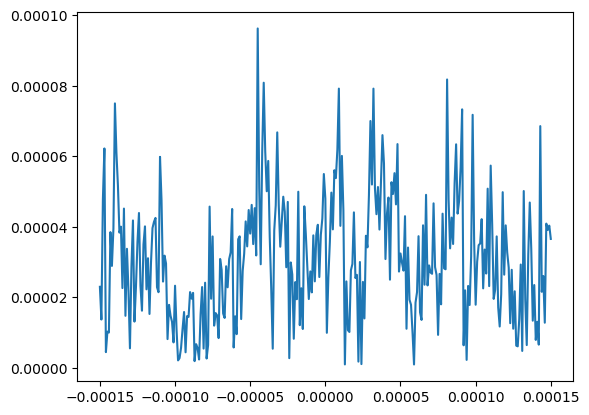

In [13]:
# For plotting current vs single resonator point
plt.plot(my_acquired_results.axis[0], np.abs(my_acquired_results.data));

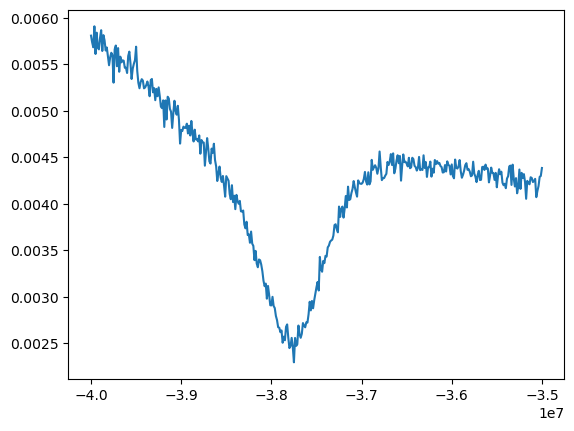

In [21]:
# For plotting trace of resonator
plt.plot(my_acquired_results.axis[0], np.abs(my_acquired_results.data));

## Old code which doesn't work (no signal measured)
For my own learning, it would be nice if I understood why this doesn't work, though it is black magic to me right now...

In [57]:
#This is old and uses the faulty single point spectroscopy section from above. Does not work for no decernible reason. Would be nice to know why though...
# exp = Experiment(
#     uid="1D_Current_Sweep",
#     signals=[
#         ExperimentSignal(uid="measure", map_to=lsg[qubit.uid]['measure_line']),
#         ExperimentSignal(uid="acquire", map_to=lsg[qubit.uid]['acquire_line']),
#         ExperimentSignal(uid="drive", map_to=lsg[qubit.uid]['drive_line'])
#     ]
# )

# with exp.sweep(
#     uid="yoko sweep",
#     parameter=coil_sweep_param,
#     execution_type=ExecutionType.NEAR_TIME,
# ):
#     with exp.acquire_loop_rt(
#         uid="shots",
#         count=averages,
#         acquisition_type=AcquisitionType.SPECTROSCOPY_IQ,
#         averaging_mode=AveragingMode.SEQUENTIAL
#     ):
#         with exp.section(uid="single_res_point_readout"):
#             exp.play(
#                 signal="measure",
#                 pulse=pulse_library.gaussian_square(
#                     uid=f"readout_pulse_{qubit.uid}",
#                     length=qubit.parameters.user_defined['readout_len'],
#                     amplitude=qubit.parameters.user_defined['readout_amp'],
#                     width=qubit.parameters.user_defined['readout_len'] * 0.9,
#                     sigma=0.2,)
#             )
#             exp.acquire(
#                 signal='acquire',
#                 handle='single_freq_data',
#                 length=qubit.parameters.user_defined['readout_len'],
#             )
#         with exp.section(uid="delay_between_readout", length=qubit.parameters.user_defined['reset_length']):
#             exp.reserve(signal="measure")
#     exp.call('change_current', new_current=coil_sweep_param, step_time=0.02)

In [22]:
#This cell is old. Seems to not actually measure anything. Would be nice to know why though...
exp = Experiment(
    uid="Single_Freq_Res",
    signals=[
        ExperimentSignal(uid="measure", map_to=lsg[qubit.uid]['measure_line']),
        ExperimentSignal(uid="acquire", map_to=lsg[qubit.uid]['acquire_line']),
        ExperimentSignal(uid="drive", map_to=lsg[qubit.uid]['drive_line'])
    ]
)

with exp.acquire_loop_rt(
    uid="shots",
    count=averages,
    acquisition_type=AcquisitionType.SPECTROSCOPY,
    # averaging_mode=AveragingMode.SEQUENTIAL
):
    with exp.section(uid="single_res_point_readout",
        trigger={'drive': {'state': 1}}):
        exp.play(
            signal="measure",
            pulse=pulse_library.gaussian_square(
                uid=f"readout_pulse_{qubit.uid}",
                length=qubit.parameters.user_defined['readout_len'],
                amplitude=qubit.parameters.user_defined['readout_amp'],
                width=qubit.parameters.user_defined['readout_len'] * 0.9,
                sigma=0.2,)
        )
        exp.acquire(
            signal='acquire',
            handle='single_freq_data',
            length=qubit.parameters.user_defined['readout_len'],
        )
    with exp.section(uid="delay_between_readout", length=qubit.parameters.user_defined['reset_length']):
        exp.reserve(signal="measure")